In [1]:
%cd /lustre/scratch126/cellgen/team205/aa34/Arian/Dis2P/dis2p_reproducibility

/lustre/scratch126/cellgen/team205/aa34/Arian/Dis2P/dis2p_reproducibility


/software/cellgen/team361/aa34/envs/disect/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
# enable autoreload
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import random

import scvi
scvi.settings.seed = 0
import scanpy as sc
import anndata as ad
import torch
import numpy as np
import pandas as pd
from datetime import datetime
from scipy.sparse import csr_matrix
torch.set_float32_matmul_precision('medium')
import warnings
warnings.simplefilter("ignore", UserWarning)
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import seaborn as sns

# from scfair.evaluate import *
# from scfair_reproducibility.evaluation.metrics import *

from celldisect import CellDISECT
import rapids_singlecell as rsc
# from dis2p_reproducibility.dis2p_defunct import dis2pvi as dvi

import scib

from sklearn.metrics import r2_score
from scipy.stats import pearsonr
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

Global seed set to 0
Global seed set to 0


In [3]:
adata = sc.read_h5ad('../haber_hvg_split.h5ad')
adata = adata[adata.layers['counts'].sum(1) != 0].copy()

In [4]:
adata.layers['counts'].max()

4385.0

In [5]:
adata.X.max()

8.89436

In [6]:
from typing import NamedTuple

class _REGISTRY_KEYS_NT(NamedTuple):
    X_KEY: str = "X"
    BATCH_KEY: str = "batch"
    LABELS_KEY: str = "labels"
    PROTEIN_EXP_KEY: str = "proteins"
    CAT_COVS_KEY: str = "extra_categorical_covs"
    CONT_COVS_KEY: str = "extra_continuous_covs"
    INDICES_KEY: str = "ind_x"
    SIZE_FACTOR_KEY: str = "size_factor"
    LATENT_MODE_KEY: str = "latent_mode"
    LATENT_QZM_KEY: str = "latent_qzm"
    LATENT_QZV_KEY: str = "latent_qzv"


REGISTRY_KEYS = _REGISTRY_KEYS_NT()

In [7]:
cats = ['batch', 'condition', 'cell_label',]
cell_type_included = True # Set to True if you have provided a cell type annotation in the cats list
if not cell_type_included:
    adata.obs["_cluster"] = (
        "0"  # Dummy obs for inference (not-training) time, to avoid computing neighbors and clusters again in setup_anndata | AVOID ADDING BEFORE TRAINING
    )
pre_path = '../models/haber_ablation_celldisect_cfW_all1/'
model_paths = []
for model_path in os.listdir(pre_path):
    model_paths.append(model_path)

In [8]:
model_paths

['celldisect_allones_cfW_6.0_split_split_allOut_TA_salmonella',
 'celldisect_allones_cfW_0.5_split_split_allOut_Enterocyte_hpoly10',
 'celldisect_allones_cfW_1.5_split_split_allOut_Goblet_salmonella',
 'celldisect_allones_cfW_0.05_split_split_allOut_Stem_hpoly10',
 'celldisect_allones_cfW_1.2_split_split_allOut_Goblet_salmonella',
 'celldisect_allones_cfW_3.0_split_split_allOut_Enterocyte_hpoly10',
 'celldisect_allones_cfW_1.0_split_split_allOut_Tuft_salmonella',
 'celldisect_allones_cfW_1.5_split_split_allOut_Tuft_salmonella',
 'celldisect_allones_cfW_1.0_split_split_allOut_Tuft_hpoly10',
 'celldisect_allones_cfW_0.8_split_split_allOut_Enterocyte_salmonella',
 'celldisect_allones_cfW_2.5_split_split_allOut_Enterocyte.Progenitor_hpoly10',
 'celldisect_allones_cfW_0.7_split_split_allOut_Enterocyte.Progenitor_hpoly10',
 'celldisect_allones_cfW_0.0_split_split_allOut_Goblet_hpoly10',
 'celldisect_allones_cfW_0.05_split_split_allOut_Enterocyte.Progenitor_hpoly10',
 'celldisect_allones_cfW_

In [16]:
from scipy.stats import wasserstein_distance
from tqdm import tqdm
import gc

ood_cts = adata.obs['cell_label'].unique()
scenario = 'allOut'

cov_names = ['condition']
cov_values = ['Control']
n_samples_from_source_max = 500

emd_results_all = []
r2_results_all = []
r2_results_subtract_all = []

for cond in ['salmonella', 'hpoly10']:
    if cond == 'salmonella':
        cov_values_cf = ['Salmonella']
    else:
        cov_values_cf = ['Hpoly.Day10']
    for cell_type_to_check in tqdm(ood_cts):
        filtered_model_paths = [path for path in model_paths if (cond in path and cell_type_to_check in path)]
        names = [name.split('_')[3] for name in filtered_model_paths]
        
        models = {}
        for i, model_path in enumerate(filtered_model_paths):
            models[names[i]] = CellDISECT.load(f"{pre_path}/{model_path}", adata=adata)
            
        models = dict(sorted(models.items(), key=lambda t: float(t[0])))
        
        gc.collect()
        n_samples_from_source = min(n_samples_from_source_max,
                                    len(adata[(adata.obs['cell_label'] == cell_type_to_check)
                                            & (adata.obs['condition'] == 'Control')]))
        
        RANDOM_SEED = 42
        preds = {}
        for name, model in models.items():
            x_ctrl, x_true, x_pred = model.predict_counterfactuals(
                                                adata[(adata.obs['cell_label'] == cell_type_to_check)].copy(),
                                                cov_names=cov_names,
                                                cov_values=cov_values,
                                                cov_values_cf=cov_values_cf,
                                                cats=cats,
                                                n_samples_from_source=n_samples_from_source,
                                                seed=RANDOM_SEED,
                                                )
            x_ctrl, x_true, x_pred = np.log1p(x_ctrl), np.log1p(x_true), np.log1p(x_pred)
            preds[name] = x_pred
        
        deg_list = adata.uns['rank_genes_groups'][f'{cell_type_to_check}_{cov_values_cf[0]}']


        emd_results = {}
        for n_top_deg in [20, None]:
            if n_top_deg is not None:
                degs = np.where(np.isin(adata.var_names, deg_list[:n_top_deg]))[0]
            else:
                degs = np.arange(adata.n_vars)
                n_top_deg = 'all'
            emd_results[str(n_top_deg)] = {}
            for name, x_pred in preds.items():
                x_true_deg = x_true[:, degs]
                x_pred_deg = x_pred[:, degs]
                # for method_name, method in zip(['CellDISECT', 'Control'], [x_pred_deg, x_ctrl_deg]):
                wd = []
                for i in range(x_true_deg.shape[1]):
                    wd.append(
                        wasserstein_distance(torch.tensor(x_true_deg[:, i]), torch.tensor(x_pred_deg[:, i]))
                    )
                emd_results[str(n_top_deg)][name] = np.mean(wd)

        emd_results = pd.DataFrame.from_dict(emd_results).T
        
        r2_results = {}
        for n_top_deg in [20, None]:
            if n_top_deg is not None:
                degs = np.where(np.isin(adata.var_names, deg_list[:n_top_deg]))[0]
            else:
                degs = np.arange(adata.n_vars)
                n_top_deg = 'all'
            r2_results[str(n_top_deg)] = {}
            for name, x_pred in preds.items():

                x_true_deg = x_true[:, degs]
                x_pred_deg = x_pred[:, degs]

                r2_mean_deg = pearsonr(x_true_deg.mean(0), x_pred_deg.mean(0))

                r2_var_deg = pearsonr(x_true_deg.var(0), x_pred_deg.var(0))

                r2_results[str(n_top_deg)][name] = r2_mean_deg[0]

                r2_results[str(n_top_deg)][name+'_var'] = r2_var_deg[0]

        r2_results = pd.DataFrame.from_dict(r2_results).T
        
        r2_results_subtract = {}
        for n_top_deg in [20, None]:
            if n_top_deg is not None:
                degs = np.where(np.isin(adata.var_names, deg_list[:n_top_deg]))[0]
            else:
                degs = np.arange(adata.n_vars)
                n_top_deg = 'all'
            r2_results_subtract[str(n_top_deg)] = {}
            for name, x_pred in preds.items():

                x_true_deg = x_true[:, degs]
                x_pred_deg = x_pred[:, degs]
                x_ctrl_deg = x_ctrl[:, degs]


                r2_mean_deg = pearsonr(x_true_deg.mean(0) - x_ctrl_deg.mean(0), x_pred_deg.mean(0) - x_ctrl_deg.mean(0))

                r2_var_deg = pearsonr(x_true_deg.var(0) - x_ctrl_deg.var(0), x_pred_deg.var(0) - x_ctrl_deg.var(0))

                r2_results_subtract[str(n_top_deg)][name] = r2_mean_deg[0]

                r2_results_subtract[str(n_top_deg)][name+'_var'] = r2_var_deg[0]

        r2_results_subtract = pd.DataFrame.from_dict(r2_results_subtract).T
        
        emd_results_all.append(emd_results)
        r2_results_all.append(r2_results)
        r2_results_subtract_all.append(r2_results_subtract)

  0%|          | 0/8 [00:00<?, ?it/s]

INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_0.1_split_split_allOut_Enterocyte.Pro
         genitor_salmonella/model.pt already downloaded                                                            
INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_3.0_split_split_allOut_Enterocyte.Pro
         genitor_salmonella/model.pt already downloaded                                                            
INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_10.0_split_split_allOut_Enterocyte.Pr
         ogenitor_salmonella/model.pt already downloaded                

 12%|█▎        | 1/8 [00:46<05:24, 46.41s/it]

INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_2.5_split_split_allOut_Stem_salmonell
         a/model.pt already downloaded                                                                             
INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_0.2_split_split_allOut_Stem_salmonell
         a/model.pt already downloaded                                                                             
INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_3.5_split_split_allOut_Stem_salmonell
         a/model.pt already downloaded                                  

 25%|██▌       | 2/8 [01:37<04:54, 49.04s/it]

INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_0.05_split_split_allOut_TA.Early_salm
         onella/model.pt already downloaded                                                                        
INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_3.0_split_split_allOut_TA.Early_salmo
         nella/model.pt already downloaded                                                                         
INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_1.0_split_split_allOut_TA.Early_salmo
         nella/model.pt already downloaded                              

 38%|███▊      | 3/8 [02:30<04:15, 51.01s/it]

INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_6.0_split_split_allOut_TA_salmonella/
         model.pt already downloaded                                                                               
INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_10.0_split_split_allOut_TA_salmonella
         /model.pt already downloaded                                                                              
INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_1.2_split_split_allOut_TA_salmonella/
         model.pt already downloaded                                    

 50%|█████     | 4/8 [03:19<03:20, 50.12s/it]

INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_1.0_split_split_allOut_Tuft_salmonell
         a/model.pt already downloaded                                                                             
INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_1.5_split_split_allOut_Tuft_salmonell
         a/model.pt already downloaded                                                                             
INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_6.0_split_split_allOut_Tuft_salmonell
         a/model.pt already downloaded                                  

 62%|██████▎   | 5/8 [03:45<02:04, 41.56s/it]

INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_0.8_split_split_allOut_Enterocyte_sal
         monella/model.pt already downloaded                                                                       
INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_0.1_split_split_allOut_Enterocyte.Pro
         genitor_salmonella/model.pt already downloaded                                                            
INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_1.5_split_split_allOut_Enterocyte_sal
         monella/model.pt already downloaded                            

 75%|███████▌  | 6/8 [04:46<01:36, 48.02s/it]

INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_1.5_split_split_allOut_Goblet_salmone
         lla/model.pt already downloaded                                                                           
INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_1.2_split_split_allOut_Goblet_salmone
         lla/model.pt already downloaded                                                                           
INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_7.5_split_split_allOut_Goblet_salmone
         lla/model.pt already downloaded                                

 88%|████████▊ | 7/8 [05:21<00:43, 43.73s/it]

INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_8.5_split_split_allOut_Endocrine_salm
         onella/model.pt already downloaded                                                                        
INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_3.0_split_split_allOut_Endocrine_salm
         onella/model.pt already downloaded                                                                        
INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_0.8_split_split_allOut_Endocrine_salm
         onella/model.pt already downloaded                             

  0%|          | 0/8 [00:00<?, ?it/s]

INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_2.5_split_split_allOut_Enterocyte.Pro
         genitor_hpoly10/model.pt already downloaded                                                               
INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_0.7_split_split_allOut_Enterocyte.Pro
         genitor_hpoly10/model.pt already downloaded                                                               
INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_0.05_split_split_allOut_Enterocyte.Pr
         ogenitor_hpoly10/model.pt already downloaded                   

 12%|█▎        | 1/8 [00:59<06:57, 59.65s/it]

INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_0.05_split_split_allOut_Stem_hpoly10/
         model.pt already downloaded                                                                               
INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_1.5_split_split_allOut_Stem_hpoly10/m
         odel.pt already downloaded                                                                                
INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_0.5_split_split_allOut_Stem_hpoly10/m
         odel.pt already downloaded                                     

 25%|██▌       | 2/8 [01:58<05:56, 59.47s/it]

INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_7.5_split_split_allOut_TA.Early_hpoly
         10/model.pt already downloaded                                                                            
INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_1.0_split_split_allOut_TA.Early_hpoly
         10/model.pt already downloaded                                                                            
INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_10.0_split_split_allOut_TA.Early_hpol
         y10/model.pt already downloaded                                

 38%|███▊      | 3/8 [02:55<04:50, 58.04s/it]

INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_10.0_split_split_allOut_TA_hpoly10/mo
         del.pt already downloaded                                                                                 
INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_7.5_split_split_allOut_TA.Early_hpoly
         10/model.pt already downloaded                                                                            
INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_2.0_split_split_allOut_TA_hpoly10/mod
         el.pt already downloaded                                       

 50%|█████     | 4/8 [03:49<03:45, 56.49s/it]

INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_1.0_split_split_allOut_Tuft_hpoly10/m
         odel.pt already downloaded                                                                                
INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_0.5_split_split_allOut_Tuft_hpoly10/m
         odel.pt already downloaded                                                                                
INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_0.1_split_split_allOut_Tuft_hpoly10/m
         odel.pt already downloaded                                     

 62%|██████▎   | 5/8 [04:19<02:21, 47.13s/it]

INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_0.5_split_split_allOut_Enterocyte_hpo
         ly10/model.pt already downloaded                                                                          
INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_3.0_split_split_allOut_Enterocyte_hpo
         ly10/model.pt already downloaded                                                                          
INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_2.5_split_split_allOut_Enterocyte.Pro
         genitor_hpoly10/model.pt already downloaded                    

 75%|███████▌  | 6/8 [05:10<01:36, 48.35s/it]

INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_0.0_split_split_allOut_Goblet_hpoly10
         /model.pt already downloaded                                                                              
INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_6.0_split_split_allOut_Goblet_hpoly10
         /model.pt already downloaded                                                                              
INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_8.5_split_split_allOut_Goblet_hpoly10
         /model.pt already downloaded                                   

 88%|████████▊ | 7/8 [05:50<00:45, 45.47s/it]

INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_0.7_split_split_allOut_Endocrine_hpol
         y10/model.pt already downloaded                                                                           
INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_1.5_split_split_allOut_Endocrine_hpol
         y10/model.pt already downloaded                                                                           
INFO     File                                                                                                      
         ../models/haber_ablation_celldisect_cfW_all1//celldisect_allones_cfW_4.0_split_split_allOut_Endocrine_hpol
         y10/model.pt already downloaded                                

100%|██████████| 8/8 [06:20<00:00, 47.58s/it]


In [14]:
emd_results_all
r2_results_all
r2_results_subtract_all

dict_keys(['Endocrine_Hpoly.Day10', 'Endocrine_Hpoly.Day3', 'Endocrine_Salmonella', 'Enterocyte.Progenitor_Hpoly.Day10', 'Enterocyte.Progenitor_Hpoly.Day3', 'Enterocyte.Progenitor_Salmonella', 'Enterocyte_Hpoly.Day10', 'Enterocyte_Hpoly.Day3', 'Enterocyte_Salmonella', 'Goblet_Hpoly.Day10', 'Goblet_Hpoly.Day3', 'Goblet_Salmonella', 'Stem_Hpoly.Day10', 'Stem_Hpoly.Day3', 'Stem_Salmonella', 'TA.Early_Hpoly.Day10', 'TA.Early_Hpoly.Day3', 'TA.Early_Salmonella', 'TA_Hpoly.Day10', 'TA_Hpoly.Day3', 'TA_Salmonella', 'Tuft_Hpoly.Day10', 'Tuft_Hpoly.Day3', 'Tuft_Salmonella'])

In [22]:
emd_results = pd.concat([df for df in emd_results_all]).groupby(level=0).mean()
r2_results = pd.concat([df for df in r2_results_all]).groupby(level=0).mean()
r2_results_subtract = pd.concat([df for df in r2_results_subtract_all]).groupby(level=0).mean()

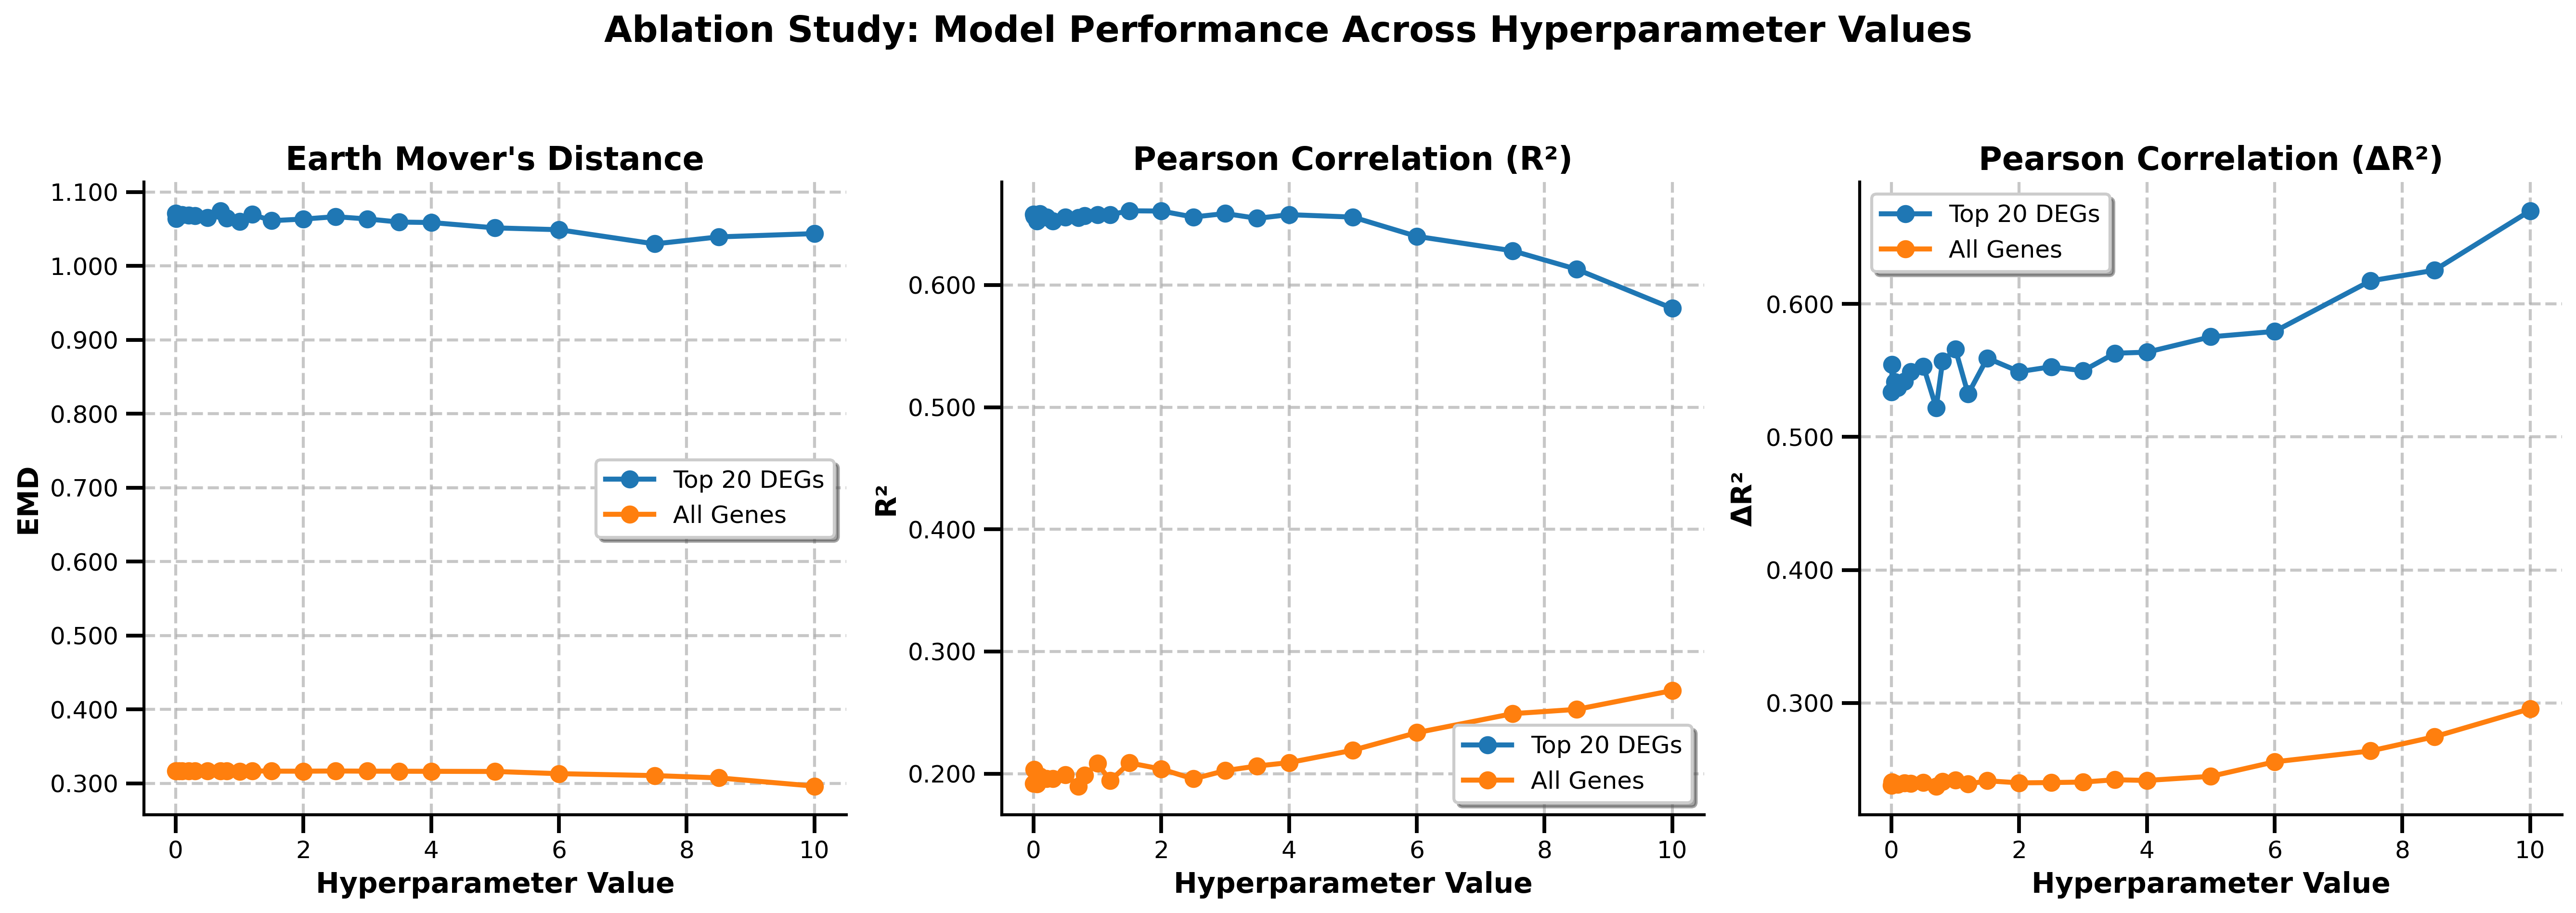

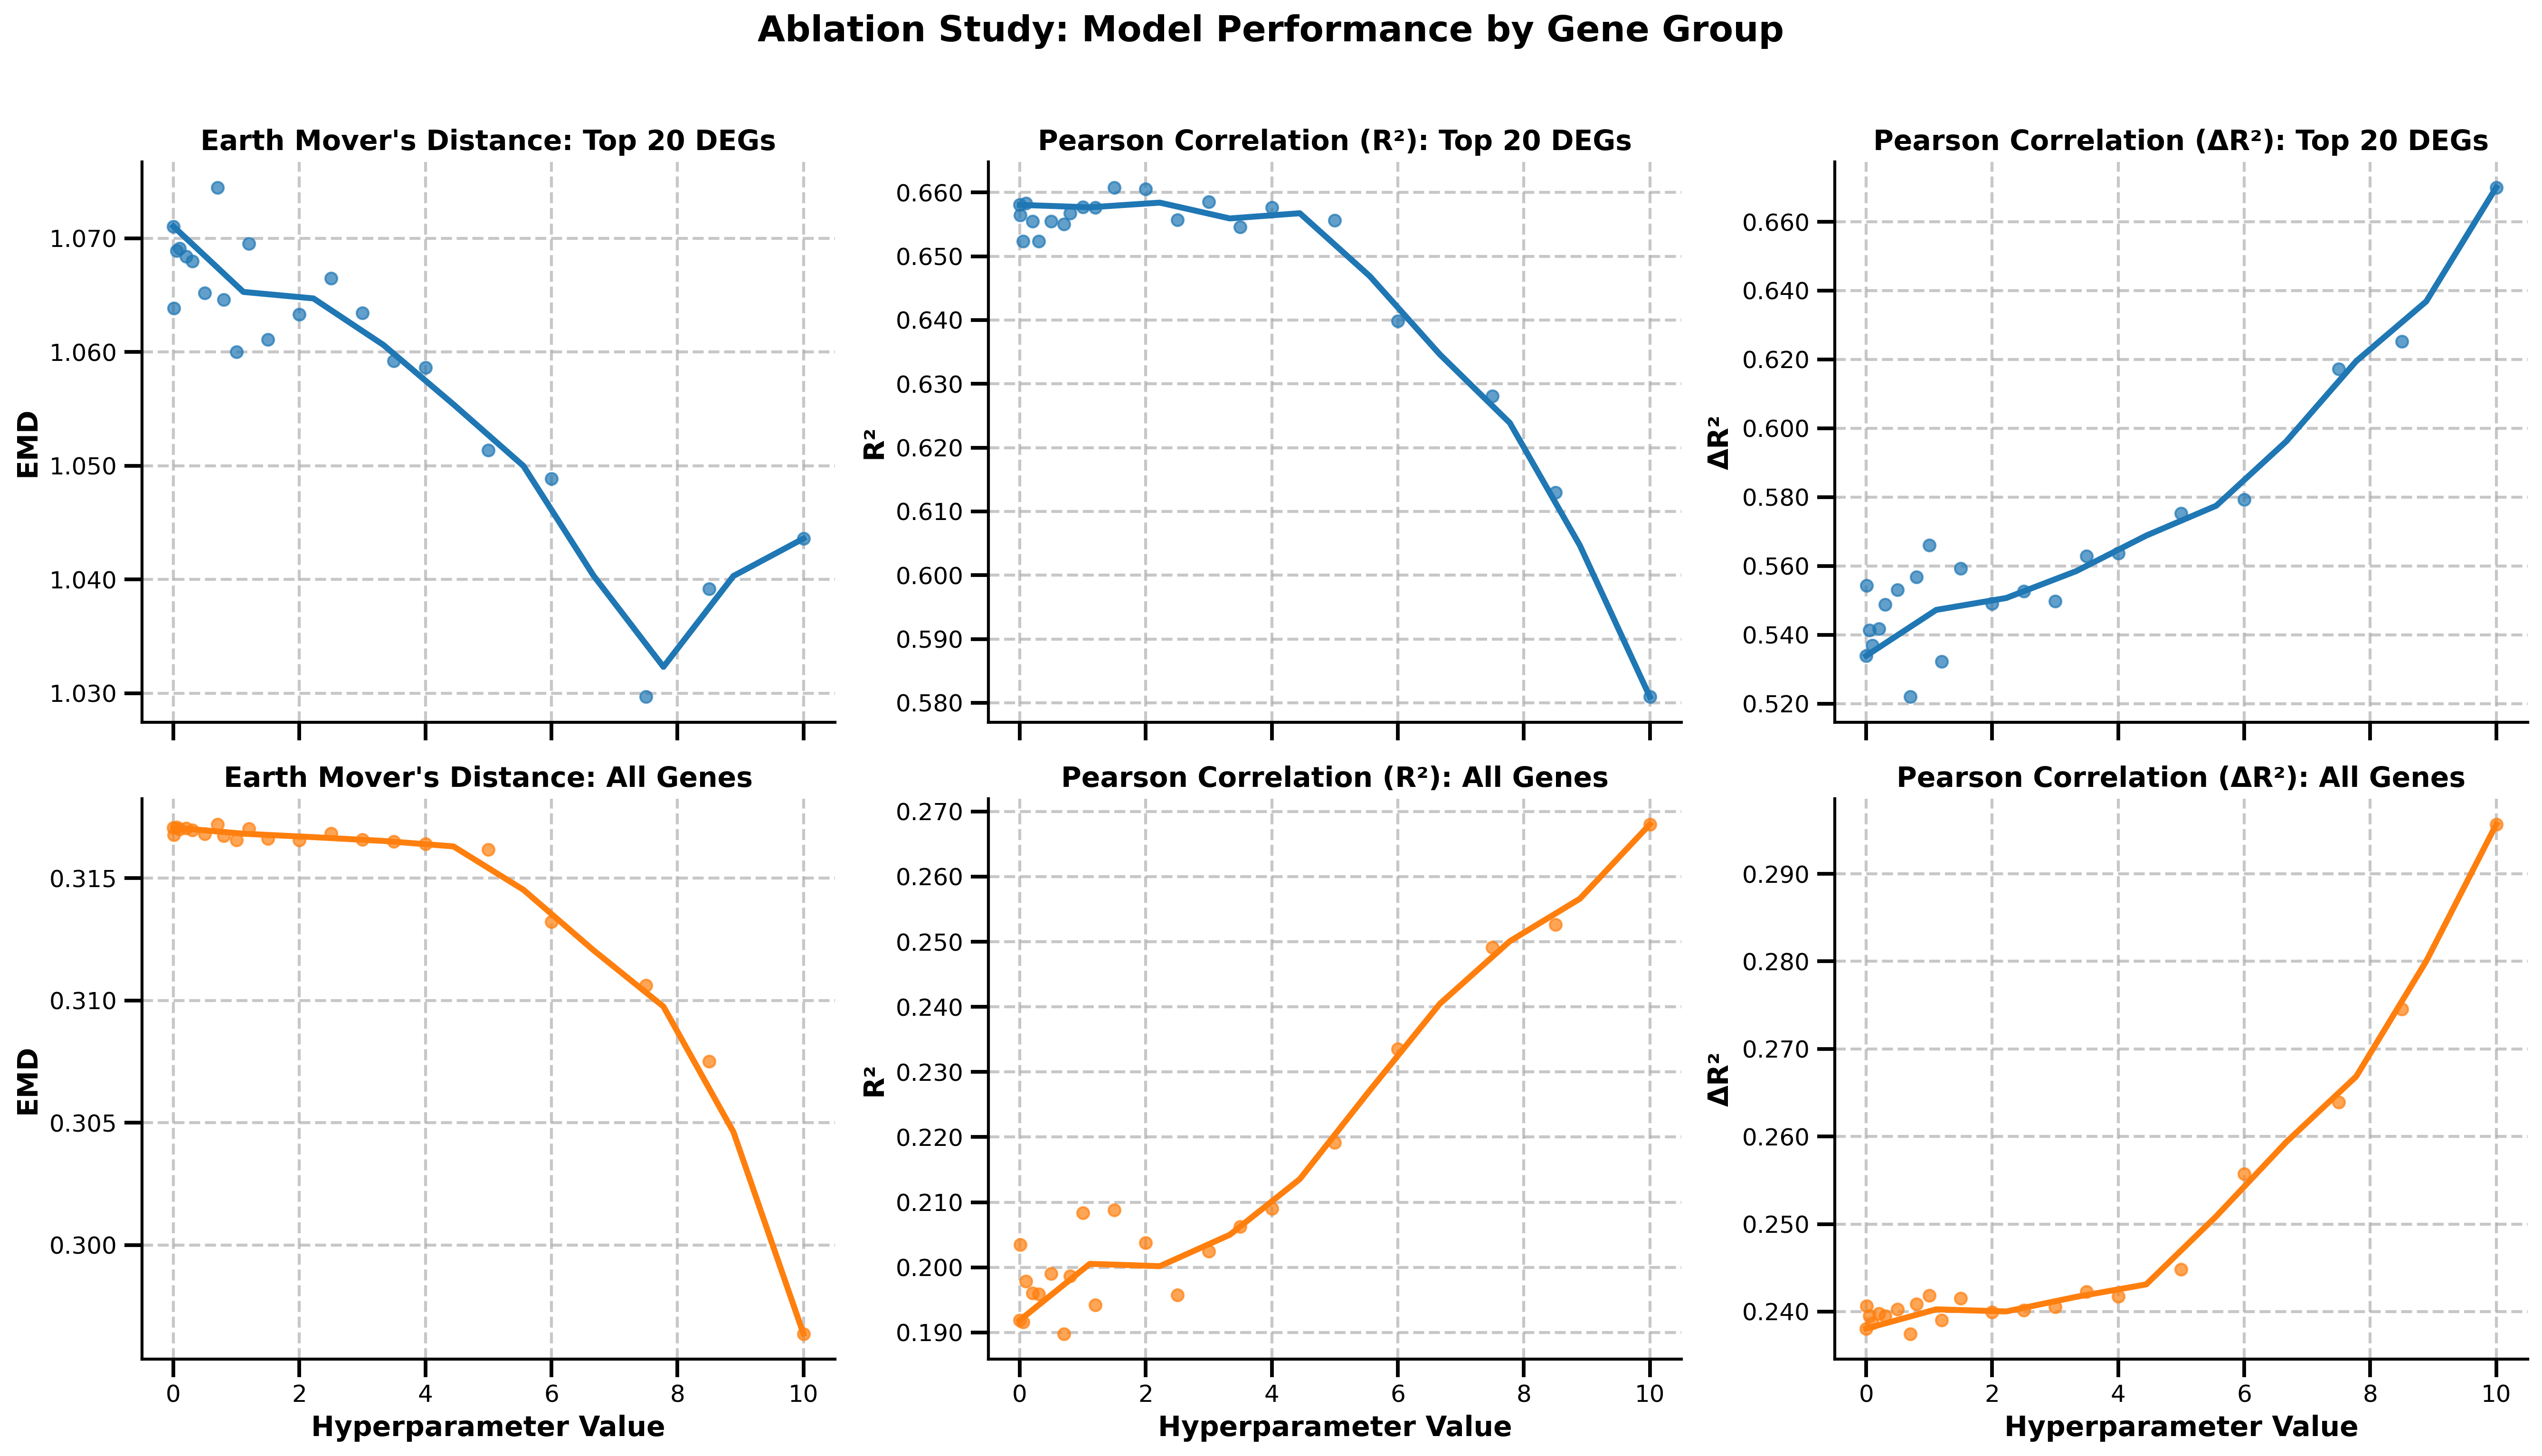

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
from scipy.interpolate import make_interp_spline

# Assuming your dataframes are already created as emd_results, r2_results, and r2_results_subtract
# Let's create a function to extract the hyperparameter values and restructure the data

def prepare_data_for_plotting(df, metric_name):
    # Get hyperparameter values (column names that are numeric)
    hyperparam_values = [col for col in df.columns if not col.endswith('_var')]
    
    # Create a new dataframe for plotting
    plot_data = []
    
    for group in df.index:
        for param in hyperparam_values:
            plot_data.append({
                'Group': 'Top 20 DEGs' if group == '20' else 'All Genes',
                'Hyperparameter': float(param),
                metric_name: df.loc[group, param]
            })
    
    return pd.DataFrame(plot_data)

# Set up the plot style for publication quality
plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'font.size': 12,
    'axes.linewidth': 1.5,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight'
})

# Create figure with 3 subplots (one for each metric)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Define colors
colors = {'Top 20 DEGs': '#1f77b4', 'All Genes': '#ff7f0e'}

# Prepare and plot each metric
metrics = {
    'EMD': emd_results,
    'R²': r2_results,
    'ΔR²': r2_results_subtract
}

metric_labels = {
    'EMD': 'Earth Mover\'s Distance',
    'R²': 'Pearson Correlation (R²)',
    'ΔR²': 'Pearson Correlation (ΔR²)'
}

for i, (metric_name, df) in enumerate(metrics.items()):
    # Prepare data
    plot_data = prepare_data_for_plotting(df, metric_name)
    
    # Create separate plots for each group to handle different scales
    for group in ['Top 20 DEGs', 'All Genes']:
        group_data = plot_data[plot_data['Group'] == group]
        
        # Plot the line
        axes[i].plot(
            group_data['Hyperparameter'], 
            group_data[metric_name], 
            'o-', 
            color=colors[group],
            linewidth=2.5,
            markersize=8,
            label=group
        )
    
    # Set titles and labels
    axes[i].set_title(metric_labels[metric_name], fontweight='bold', fontsize=16)
    axes[i].set_xlabel('Hyperparameter Value', fontweight='bold')
    axes[i].set_ylabel(metric_name, fontweight='bold')
    
    # Format y-axis to show more decimals
    axes[i].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    
    # Add grid for better readability
    axes[i].grid(True, linestyle='--', alpha=0.7)
    
    # Add legend
    axes[i].legend(frameon=True, fancybox=True, shadow=True)
    
    # Use tight layout for better spacing
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)

# Add a common title
plt.suptitle('Ablation Study: Model Performance Across Hyperparameter Values', 
             fontsize=18, fontweight='bold', y=1.05)

# Function to create smooth curve
def smooth_curve(x, y, smoothness=10):
    x_new = np.linspace(min(x), max(x), smoothness)
    spl = make_interp_spline(x, y, k=1)  # Use cubic spline (k=3)
    y_smooth = spl(x_new)
    return x_new, y_smooth

# Create a secondary plot with smoothed lines for better visualization with different y-scales
fig2, axes2 = plt.subplots(2, 3, figsize=(18, 10), sharex=True)

for i, (metric_name, df) in enumerate(metrics.items()):
    # Prepare data
    plot_data = prepare_data_for_plotting(df, metric_name)
    
    # Plot Top 20 DEGs on top row
    top_data = plot_data[plot_data['Group'] == 'Top 20 DEGs']
    x = top_data['Hyperparameter'].values
    y = top_data[metric_name].values
    
    # Sort data by hyperparameter value to ensure proper smoothing
    sort_idx = np.argsort(x)
    x_sorted = x[sort_idx]
    y_sorted = y[sort_idx]
    
    # Create smoothed curve
    x_smooth, y_smooth = smooth_curve(x_sorted, y_sorted)
    
    # Plot both the original points and the smoothed line
    axes2[0, i].plot(x_smooth, y_smooth, '-', color=colors['Top 20 DEGs'], linewidth=3)
    axes2[0, i].plot(x, y, 'o', color=colors['Top 20 DEGs'], markersize=6, alpha=0.7)
    
    axes2[0, i].set_title(f'{metric_labels[metric_name]}: Top 20 DEGs', fontweight='bold', fontsize=14)
    axes2[0, i].set_ylabel(metric_name, fontweight='bold')
    axes2[0, i].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    axes2[0, i].grid(True, linestyle='--', alpha=0.7)
    axes2[0, i].spines['top'].set_visible(False)
    axes2[0, i].spines['right'].set_visible(False)
    
    # Plot All Genes on bottom row
    all_data = plot_data[plot_data['Group'] == 'All Genes']
    x = all_data['Hyperparameter'].values
    y = all_data[metric_name].values
    
    # Sort data by hyperparameter value
    sort_idx = np.argsort(x)
    x_sorted = x[sort_idx]
    y_sorted = y[sort_idx]
    
    # Create smoothed curve
    x_smooth, y_smooth = smooth_curve(x_sorted, y_sorted)
    
    # Plot both the original points and the smoothed line
    axes2[1, i].plot(x_smooth, y_smooth, '-', color=colors['All Genes'], linewidth=3)
    axes2[1, i].plot(x, y, 'o', color=colors['All Genes'], markersize=6, alpha=0.7)
    
    axes2[1, i].set_title(f'{metric_labels[metric_name]}: All Genes', fontweight='bold', fontsize=14)
    axes2[1, i].set_xlabel('Hyperparameter Value', fontweight='bold')
    axes2[1, i].set_ylabel(metric_name, fontweight='bold')
    axes2[1, i].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    axes2[1, i].grid(True, linestyle='--', alpha=0.7)
    axes2[1, i].spines['top'].set_visible(False)
    axes2[1, i].spines['right'].set_visible(False)

plt.suptitle('Ablation Study: Model Performance by Gene Group', 
             fontsize=18, fontweight='bold', y=1.02)

# Adjust layout
fig.tight_layout()
fig2.tight_layout()

# Save the figures
fig.savefig('ablation_study_metrics_combined.png', bbox_inches='tight', dpi=300)
fig2.savefig('ablation_study_metrics_separate_smoothed.png', bbox_inches='tight', dpi=300)

# Display the figures
plt.show()

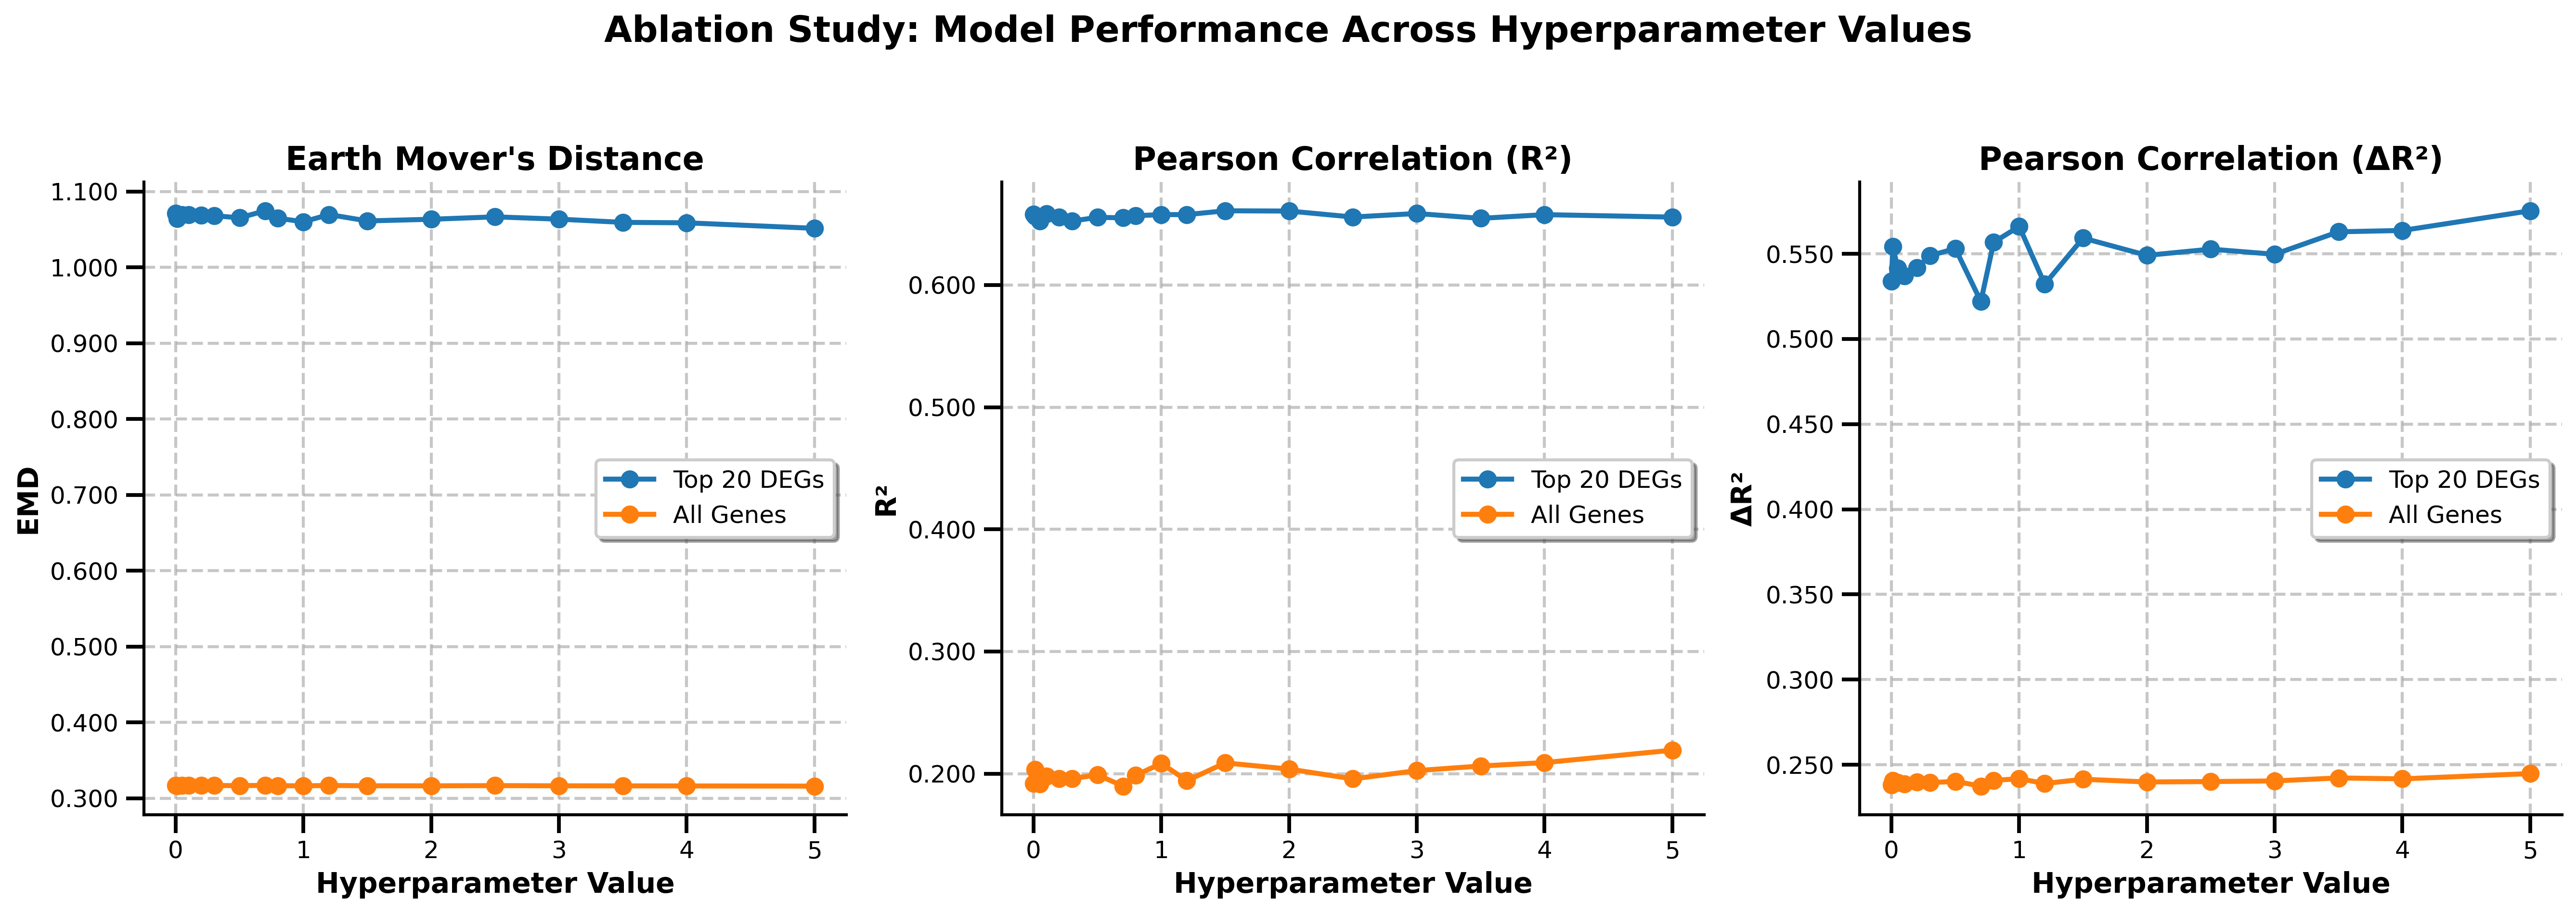

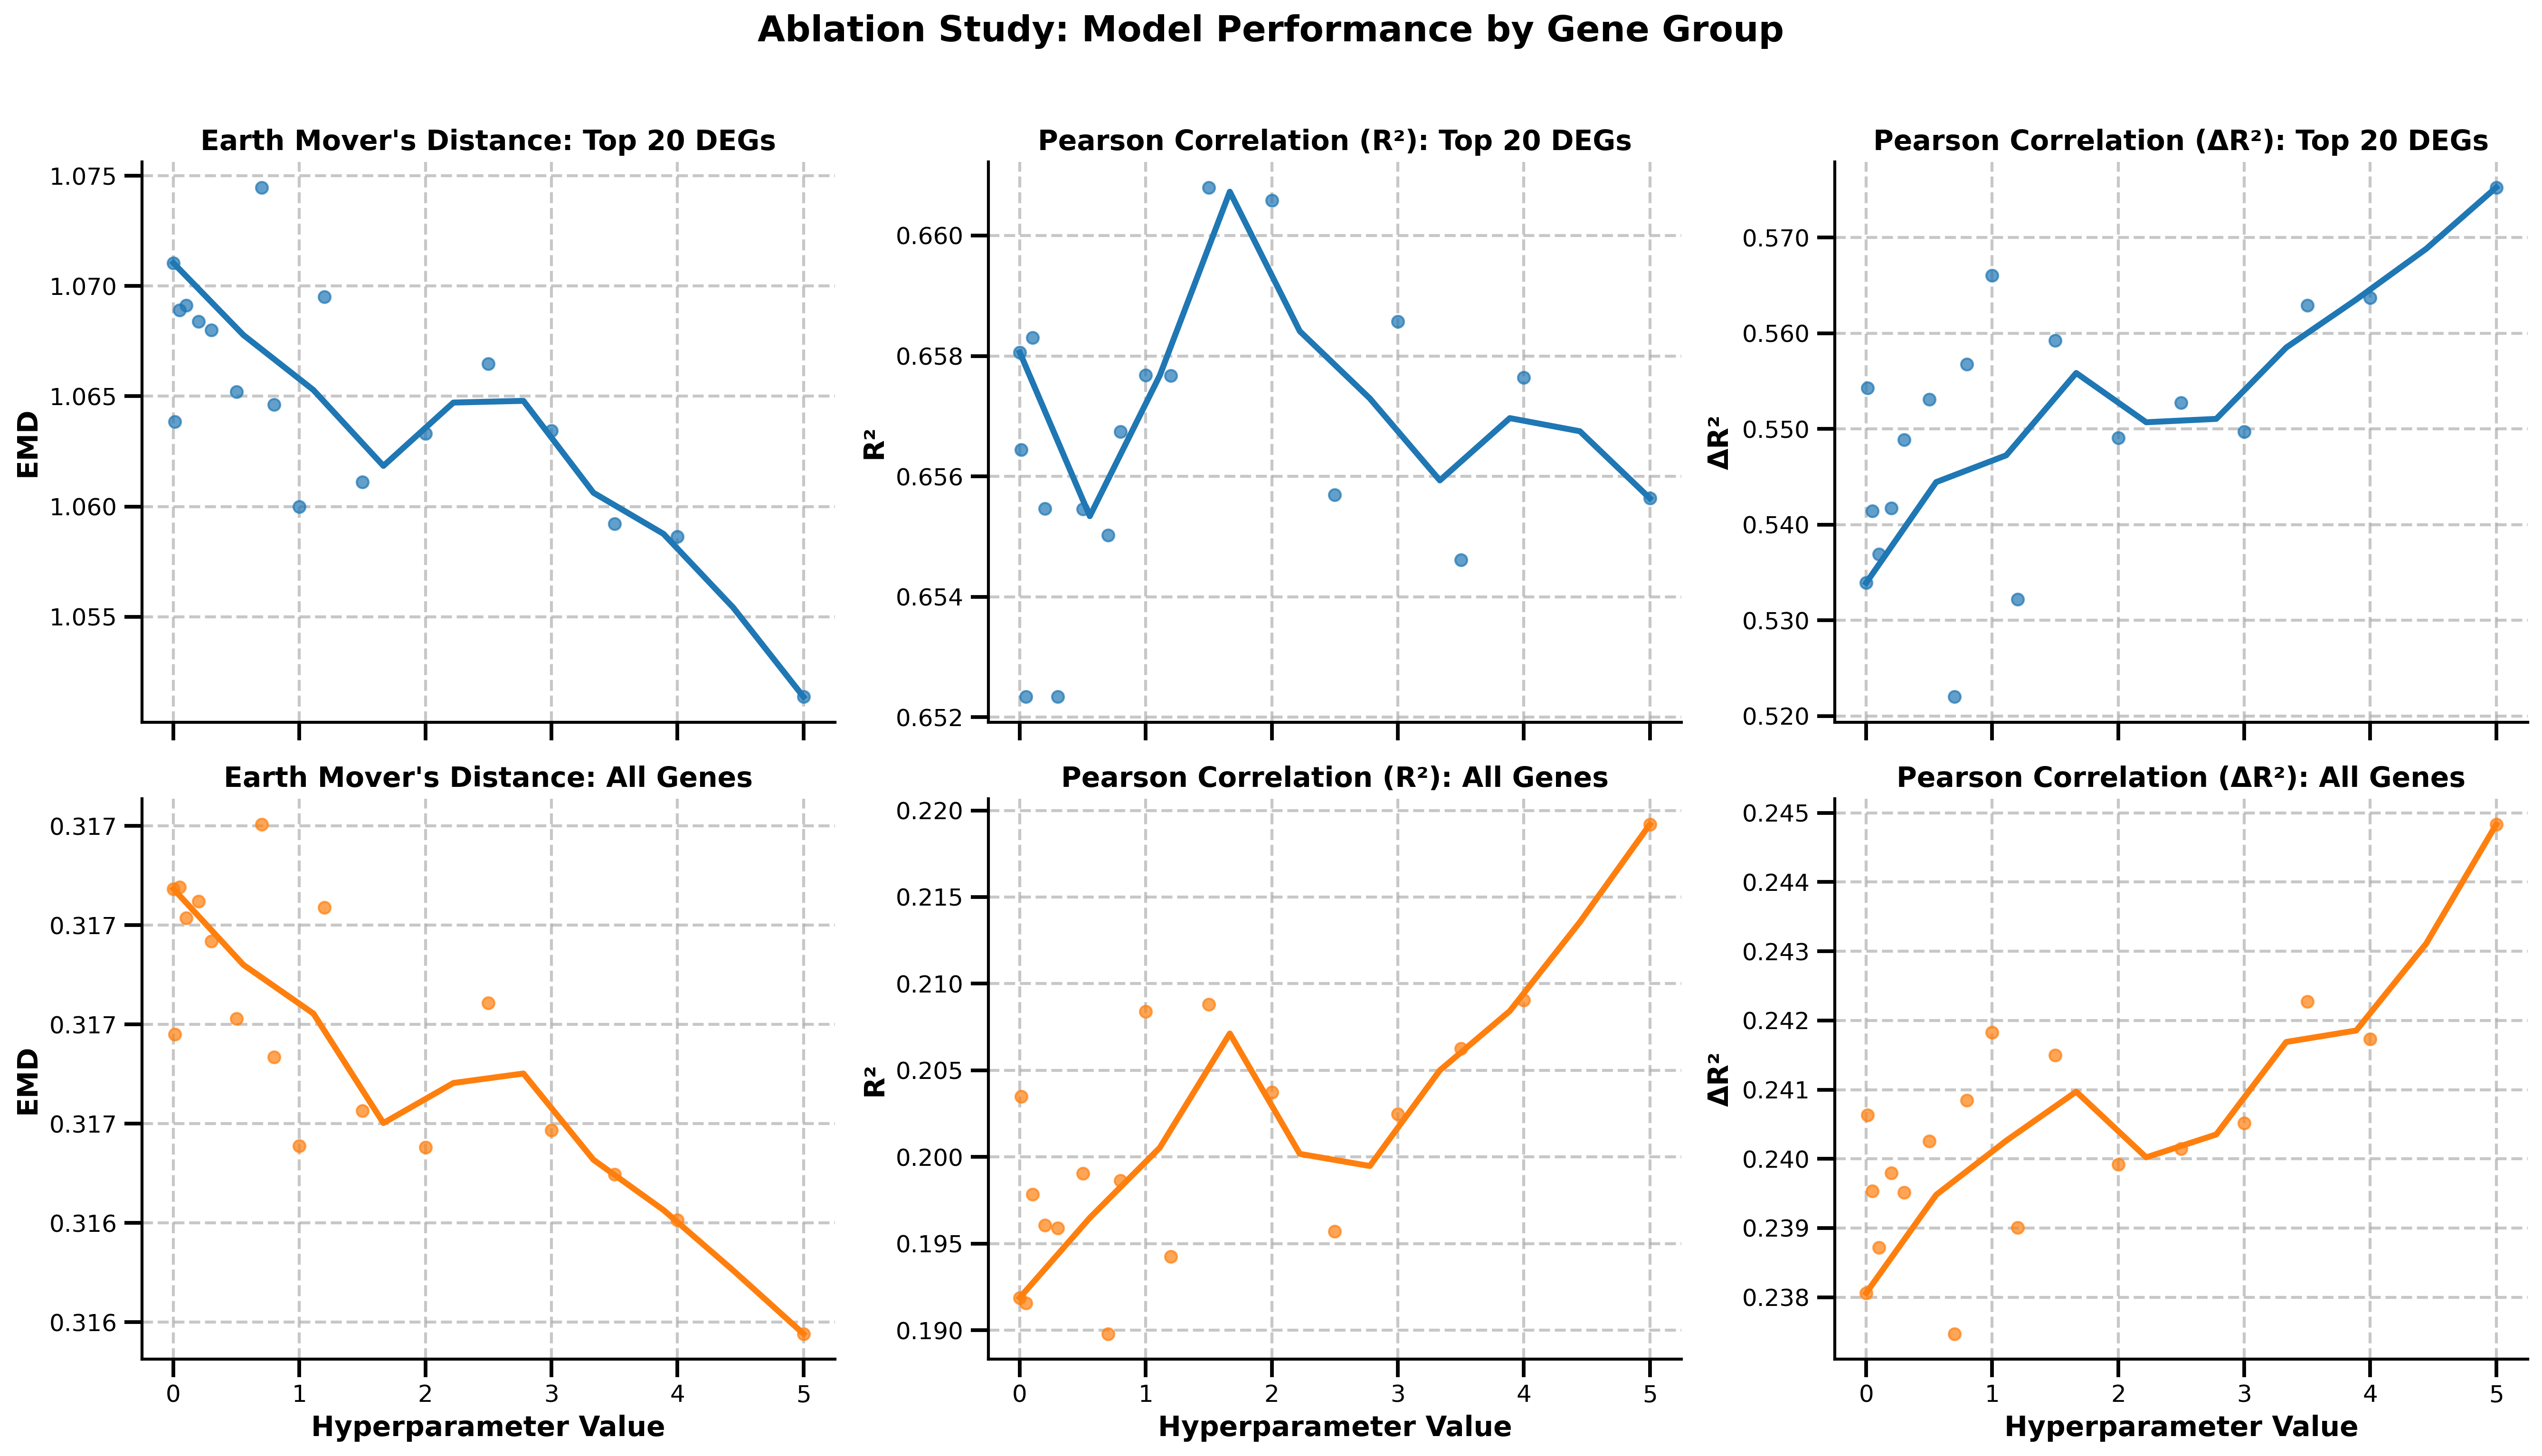

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
from scipy.interpolate import make_interp_spline

# Assuming your dataframes are already created as emd_results, r2_results, and r2_results_subtract
# Let's create a function to extract the hyperparameter values and restructure the data

def prepare_data_for_plotting(df, metric_name, max_weight=None):
    # Get hyperparameter values (column names that are numeric)
    hyperparam_values = [col for col in df.columns if not col.endswith('_var')]
    if max_weight is not None:
        hyperparam_values = [col for col in hyperparam_values if float(col) <= max_weight]
        
    
    # Create a new dataframe for plotting
    plot_data = []
    
    for group in df.index:
        for param in hyperparam_values:
            plot_data.append({
                'Group': 'Top 20 DEGs' if group == '20' else 'All Genes',
                'Hyperparameter': float(param),
                metric_name: df.loc[group, param]
            })
    
    return pd.DataFrame(plot_data)

# Set up the plot style for publication quality
plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'font.size': 12,
    'axes.linewidth': 1.5,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight'
})

# Create figure with 3 subplots (one for each metric)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Define colors
colors = {'Top 20 DEGs': '#1f77b4', 'All Genes': '#ff7f0e'}

# Prepare and plot each metric
metrics = {
    'EMD': emd_results,
    'R²': r2_results,
    'ΔR²': r2_results_subtract
}

metric_labels = {
    'EMD': 'Earth Mover\'s Distance',
    'R²': 'Pearson Correlation (R²)',
    'ΔR²': 'Pearson Correlation (ΔR²)'
}

for i, (metric_name, df) in enumerate(metrics.items()):
    # Prepare data
    plot_data = prepare_data_for_plotting(df, metric_name, max_weight=5)
    
    # Create separate plots for each group to handle different scales
    for group in ['Top 20 DEGs', 'All Genes']:
        group_data = plot_data[plot_data['Group'] == group]
        
        # Plot the line
        axes[i].plot(
            group_data['Hyperparameter'], 
            group_data[metric_name], 
            'o-', 
            color=colors[group],
            linewidth=2.5,
            markersize=8,
            label=group
        )
    
    # Set titles and labels
    axes[i].set_title(metric_labels[metric_name], fontweight='bold', fontsize=16)
    axes[i].set_xlabel('Hyperparameter Value', fontweight='bold')
    axes[i].set_ylabel(metric_name, fontweight='bold')
    
    # Format y-axis to show more decimals
    axes[i].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    
    # Add grid for better readability
    axes[i].grid(True, linestyle='--', alpha=0.7)
    
    # Add legend
    axes[i].legend(frameon=True, fancybox=True, shadow=True)
    
    # Use tight layout for better spacing
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)

# Add a common title
plt.suptitle('Ablation Study: Model Performance Across Hyperparameter Values', 
             fontsize=18, fontweight='bold', y=1.05)

# Function to create smooth curve
def smooth_curve(x, y, smoothness=10):
    x_new = np.linspace(min(x), max(x), smoothness)
    spl = make_interp_spline(x, y, k=1)  # Use cubic spline (k=3)
    y_smooth = spl(x_new)
    return x_new, y_smooth

# Create a secondary plot with smoothed lines for better visualization with different y-scales
fig2, axes2 = plt.subplots(2, 3, figsize=(18, 10), sharex=True)

for i, (metric_name, df) in enumerate(metrics.items()):
    # Prepare data
    plot_data = prepare_data_for_plotting(df, metric_name, max_weight=5)
    
    # Plot Top 20 DEGs on top row
    top_data = plot_data[plot_data['Group'] == 'Top 20 DEGs']
    x = top_data['Hyperparameter'].values
    y = top_data[metric_name].values
    
    # Sort data by hyperparameter value to ensure proper smoothing
    sort_idx = np.argsort(x)
    x_sorted = x[sort_idx]
    y_sorted = y[sort_idx]
    
    # Create smoothed curve
    x_smooth, y_smooth = smooth_curve(x_sorted, y_sorted)
    
    # Plot both the original points and the smoothed line
    axes2[0, i].plot(x_smooth, y_smooth, '-', color=colors['Top 20 DEGs'], linewidth=3)
    axes2[0, i].plot(x, y, 'o', color=colors['Top 20 DEGs'], markersize=6, alpha=0.7)
    
    axes2[0, i].set_title(f'{metric_labels[metric_name]}: Top 20 DEGs', fontweight='bold', fontsize=14)
    axes2[0, i].set_ylabel(metric_name, fontweight='bold')
    axes2[0, i].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    axes2[0, i].grid(True, linestyle='--', alpha=0.7)
    axes2[0, i].spines['top'].set_visible(False)
    axes2[0, i].spines['right'].set_visible(False)
    
    # Plot All Genes on bottom row
    all_data = plot_data[plot_data['Group'] == 'All Genes']
    x = all_data['Hyperparameter'].values
    y = all_data[metric_name].values
    
    # Sort data by hyperparameter value
    sort_idx = np.argsort(x)
    x_sorted = x[sort_idx]
    y_sorted = y[sort_idx]
    
    # Create smoothed curve
    x_smooth, y_smooth = smooth_curve(x_sorted, y_sorted)
    
    # Plot both the original points and the smoothed line
    axes2[1, i].plot(x_smooth, y_smooth, '-', color=colors['All Genes'], linewidth=3)
    axes2[1, i].plot(x, y, 'o', color=colors['All Genes'], markersize=6, alpha=0.7)
    
    axes2[1, i].set_title(f'{metric_labels[metric_name]}: All Genes', fontweight='bold', fontsize=14)
    axes2[1, i].set_xlabel('Hyperparameter Value', fontweight='bold')
    axes2[1, i].set_ylabel(metric_name, fontweight='bold')
    axes2[1, i].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    axes2[1, i].grid(True, linestyle='--', alpha=0.7)
    axes2[1, i].spines['top'].set_visible(False)
    axes2[1, i].spines['right'].set_visible(False)

plt.suptitle('Ablation Study: Model Performance by Gene Group', 
             fontsize=18, fontweight='bold', y=1.02)

# Adjust layout
fig.tight_layout()
fig2.tight_layout()

# Save the figures
fig.savefig('ablation_study_metrics_combined.png', bbox_inches='tight', dpi=300)
fig2.savefig('ablation_study_metrics_separate_smoothed.png', bbox_inches='tight', dpi=300)

# Display the figures
plt.show()

In [28]:
emd_results

,0.0,0.01,0.05,0.1,0.2,0.3,0.5,0.7,0.8,1.0,...,2.0,2.5,3.0,3.5,4.0,5.0,6.0,7.5,8.5,10.0
20,1.071044,1.063839,1.068916,1.069133,1.068383,1.067994,1.065202,1.074472,1.064622,1.059997,...,1.063300,1.066480,1.063440,1.059215,1.058630,1.051369,1.048885,1.029693,1.039161,1.043604
all,0.317073,0.316780,0.317077,0.317015,0.317048,0.316968,0.316811,0.317203,0.316734,0.316555,...,0.316553,0.316843,0.316587,0.316497,0.316406,0.316177,0.313212,0.310615,0.307513,0.296368


In [7]:
!ls -lsthr /lustre/scratch126/cellgen/team205/aa34/Arian/Dis2P/models/kang_ablation_celldisect_cfW_all1_focused/

total 80K
4.0K drwxr-sr-x 2 aa34 team205 4.0K Apr 23 14:56 'celldisect_allones_cfW_2.5_split_split_CD14 Mono'
4.0K drwxr-sr-x 2 aa34 team205 4.0K Apr 23 14:56 'celldisect_allones_cfW_8.0_split_split_CD14 Mono'
4.0K drwxr-sr-x 2 aa34 team205 4.0K Apr 23 14:56 'celldisect_allones_cfW_4.5_split_split_CD14 Mono'
4.0K drwxr-sr-x 2 aa34 team205 4.0K Apr 23 14:56 'celldisect_allones_cfW_0.8_split_split_CD14 Mono'
4.0K drwxr-sr-x 2 aa34 team205 4.0K Apr 23 14:59 'celldisect_allones_cfW_9.0_split_split_CD14 Mono'
4.0K drwxr-sr-x 2 aa34 team205 4.0K Apr 23 14:59 'celldisect_allones_cfW_5.0_split_split_CD14 Mono'
4.0K drwxr-sr-x 2 aa34 team205 4.0K Apr 23 14:59 'celldisect_allones_cfW_4.0_split_split_CD14 Mono'
4.0K drwxr-sr-x 2 aa34 team205 4.0K Apr 23 14:59 'celldisect_allones_cfW_3.5_split_split_CD14 Mono'
4.0K drwxr-sr-x 2 aa34 team205 4.0K Apr 23 14:59 'celldisect_allones_cfW_3.0_split_split_CD14 Mono'
4.0K drwxr-sr-x 2 aa34 team205 4.0K Apr 23 14:59 'celldisect_allones_cfW_2.0_split_split_C

In [6]:
!pwd

/nfs/users/nfs_a/aa34/figures/Final_Figures/CellDISECT_reproducibility/figure_notebooks/eraslan


In [ ]:
/lustre/scratch126/cellgen/team205/aa34/Arian/Dis2P/dis2p_reproducibility